# Tabu search
Algorytm tabu sam w sobie nie jest algorytmem, a przepisem jak taki algorytm
przygotować w zależności od przedstawionego problemu. Składa się on z 5 podstawowych kroków

## Tworzenie algorytmu

### 1. Inicjalizacja rozwiązania początkowego ###

Jest to rozwiązanie od którego zaczniemy poszukiwanie naszego rozwiązania minimalnego. W naszym przypadku robimy
to na 4 sposoby

```{python}
def initialize_shedule(times, method="random"):
    if method == "neh":
        return NEHmodifications.neh_ext4(times)[0]
    if method == "johnson":
        return Johnson.multi_machines_Johnson(times)
    if method == "random":
        tmp = list(range(1, len(times)+1))
        random.shuffle(tmp)
        return tmp
    if method == "sequence":
        return list(range(1, len(times)+1))
```

Jak widzimy jako pierwsze rozwiązanie możemy przyjąć wynik działania innego algorytmu (neh lub Johnsona),
sekwencje 1,2,3,4..., albo zupełnie losową kolejność

### 2. Geneowanie sąsiedztwa ###

Zastosowaliśmy trzy sposoby generowania sąsiedztw: swap, inverse i insert. Do funkcji inverse dodaliśmy
również opcje zmiany długości fragmentu listy która będzie odwracana.

```{python}
def neighbourhoods_generator(schedule, function="swap", inverse_len=4):
    neighbourhoods_list = []
    functions = function.split(",")
    if "swap" in functions:
        neighbourhoods_list.extend(swap_neighbourhoods(schedule, neighbourhoods=neighbourhoods_list[:]))

    if "insert" in functions:
        neighbourhoods_list.extend(insert_neighbourhoods(schedule, neighbourhoods=neighbourhoods_list[:]))

    if "inverse" in functions:
        neighbourhoods_list.extend(inverse_neighbourhoods(schedule, neighbourhoods=neighbourhoods_list[:], inverse_len=inverse_len))
    return neighbourhoods_list
```

Jak widzimy funkcja jest przystosowana do użycia więcej niż jednego spsobu na generowania sąsiedztw

Sama przykłądowa funkcja wygląda następująco (w tym wypadku funkcja swap)
```{python}
def swap_neighbourhoods(schedule, neighbourhoods):
    for i in range(0, len(schedule)):
        temp_schedule = schedule[:]
        for j in range(i + 1, len(schedule)):
            temp_schedule[i], temp_schedule[j] = temp_schedule[j], temp_schedule[i]
            if temp_schedule not in neighbourhoods:
                neighbourhoods.append(temp_schedule[:])
            temp_schedule[i], temp_schedule[j] = temp_schedule[j], temp_schedule[i]
    return neighbourhoods
```

### 3. Wybranie najlepszego sąsiada ###
Teraz z naszej listy sąsiedztw musimy wybrać element który najlepiej sepłnia naszą funkcje celu
(w tym wypadku dążymy do jak najmniejszego Cmax. W razie nie wystąpienia zadowalającego nas Cmax
dodaliśmy opcje powrotu do elementów z listy Tabu.

```{python}
def best_neighbourhood(schedules, times, tabu, current):
    cmin = Cmax.count_cmax(current, list((map(list, zip(*times)))))
    change = False
    tmp = schedules[0]
    for schedule in schedules:
        if schedule not in tabu:
            cmax = Cmax.count_cmax(schedule, list((map(list, zip(*times)))))
            if cmax < cmin:
                cmin = cmax
                tmp = schedule
                change = True
    if not change:
        for schedule in tabu:
            cmax = Cmax.count_cmax(schedule, list((map(list, zip(*times)))))
            if cmax < cmin:
                cmin = cmax
                tmp = schedule

    return cmin, tmp
```
Dodaliśmy również mechanizm sprawdzający czy dany element już nie został uwzględniony w innej funkcji
w liście sąsiedztw
### 4. Lista tabu ###
Nie zdefiniowaliśmy twardo maksymalnej wielkości listy tabu. Uznaliśmy to za element które należy poddać badaniom.
Zastosowaliśmy tu jednak podejście przetrzymywania wszystkich wartości jakie odwiedziliśmy, jednak faktyczne
uwzględnienie konkretnej ilości zależnie od tego jak przebiega algorytm. Uznaliśmy że jeżeli funkcja nam
utknie w jakimś punkcie to warto stopniowo pomniejszać naszą liste tabu aby sprawdzić czy to pozwoli
nam z niej wyjść

### 5. Kryterium stopu ###

Zastosowaliśmy 4 kryteria stopu:
- Ograniczenie czzasowe -  Co każdą iteracje sprawdzamy czy nie przekroczyliśmy pewnego zadanego
przez nas wcześniej czasu
- Ograniczenie iteracyjne - Wykonujemy określoną ilość iteracji
- Ograniczenie braku poprawy Cmax - Przerwamy po określonej ilości iteracji bez poprawy naszego Cmax
- Nigdy nie zatrzymujemy - Musimy ręcznie wymusić zatrzymanie (nie jest to co prawda zbyt dobra praktyka
i wolelibyśmy żeby program się zakończył w bardziej naturalny sposób). Program co każdą iteracje zapisuje
nam wynik do pliku dzięki czemu mamy do niego później dostęp.

Dodatkowo z racji że algorytm może wpaść w minimum z którego nie wyjdzie i pracować,
dodaliśmy opcje zresetowania wraz z zapamiętaniem dotychczsowego najlepszego wyniku
(obecnie tylko przy kryterium stop i time)

## Optymalizacja ##
Jak widzimy algorytm jest dosyć otwarty i jest wiele rzeczy do ustawienia w zależności od
problemu z jakim przyjdzie nam się mierzyć, mimo że nie zaimplementowaliśmy wszystkich jego możliwości
(na przykład spokojnie można dodać ograniczenia co do ilości sąsiadów).
#### Wybór sąsiada ####
W pierwszej kolejności zainicjuje przykładowe rozwiązanie o różnych długościach i zbadamy czas
jaki każda z nich potrzebuje żeby wygenerowani zostali jej sąsiedzi

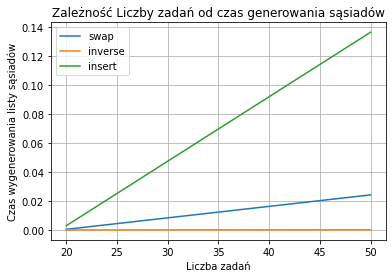

In [2]:
import TS
from time import perf_counter
from matplotlib import pyplot as plt
leng = [20, 50, 80, 100, 150, 200]
functions = ["swap", "inverse", "insert"]
schedules = [list(range(1, x+1)) for x in leng]
y = [len(x) for x in schedules]
times = {k: [] for k in functions}
for function in functions:
    for schedule in schedules:
        start = perf_counter()
        TS.neighbourhoods_generator(schedule, function=function)
        times[function].append(perf_counter()-start)
    plt.plot(leng, times[function], label=function)
plt.legend()
plt.grid()
plt.title("Zależność Liczby zadań od czas generowania sąsiadów")
plt.xlabel("Liczba zadań")
plt.ylabel("Czas wygenerowania listy sąsiadów")
plt.show()

Jak widać czasy wygenerowania listy sąsiadów potrafią znacząco się różnić sprawdźmy na przykładowych danych
zwaierających 100 zadań, jak wygląda efektywność znajdowania najlepszego Cmax. Jako inicjujące rozwiązanie
przyjmiemy sobie sequence. Dzięki temu wszędzie zaczniemy od jednakowego rozwiązania które niepowinno być
bliskie poprawnemu

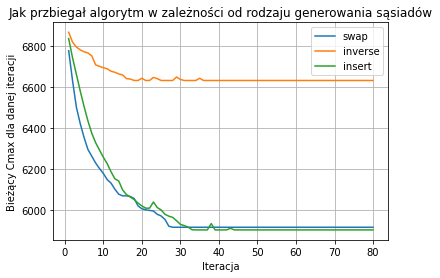

In [3]:
import Load
data = Load.read_datest("Data/data.txt")[80]
init = "sequence"
stop_func = "iter"
iter=80
history = {k: [] for k in functions}
iterations = list(range(1, iter+1))
for function in functions:
    history[function] = TS.Tabu_search(data, stop=stop_func, init_function=init,
                                   iter=iter, neighbourhoods_function=str(function),)[2]
    plt.plot(iterations, history[function], label=function)

plt.legend()
plt.grid()
plt.title("Jak przbiegał algorytm w zależności od rodzaju generowania sąsiadów")
plt.xlabel("Iteracja")
plt.ylabel("Bieżący Cmax dla danej iteracji")
plt.show()

Jak widzimy znajdowanie sąsiadów po przez inverse jest bardzo nieefektywne i mimo że jest to najszybszy
algorytm szukania sąsiadów to nie opłaca się rozwiązywać naszego problemu tylko przy jego pomocy.
Zdecydowanie lepiej żeby służył on jako pomocniczy. Jako dodatkowe zastosowanie tego algorytmu można
wykorzystać wygenerowanie przy jego pomocy znacznie bardziej odległych sąsiadów
```{python}
def global_neighbourhoods(current, zones, zone_scale):
    tmp = []
    tmp_neigh = neighbourhoods_generator(current, function="inverse",
                                                  inverse_len=len(current)-zones)
    for neigh in tmp_neigh:
        print(neigh)
        tmp.extend(neighbourhoods_generator(neigh, function="inverse",
                                                    inverse_len=len(current)-zone_scale)
```

Jest to rozwiązanie którego ostatecznie w żaden sposób nie użyliśmy przy implementacji algorytmu i nie wiemy na ile
faktycznie można je wykorzystać. Założenie jest takie że generujemy pewną ilość sąsiadów (zones), z czego im jest ich
więcej tym bardziej są odlegliod pierowtnego sąsiada, a następnie na podstawie odpowiednio dobranej funkcji zones_scale
dla każdego wcześniej wygenerowanego sąsiada, generujemy dodatkowych sąsiadów. Dzięki temu możemy przejrzeć czy któryś
z bardziej odległych obszarów ma potencjał do bycia lepszym niż obecny


Przyjrzyjmy się jednak jak poradzi sobie nasz alogrytm kiedy sąsiedzi będą wyszukiwani jednocześnie przy pomocy
inverse i swap

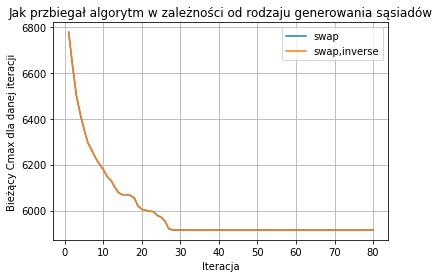

In [4]:
functions = ["swap", "swap,inverse"]
history = {k: [] for k in functions}
for function in functions:
    history[function] = TS.Tabu_search(data, stop=stop_func, init_function=init,
                                   iter=iter, neighbourhoods_function=str(function),)[2]
    plt.plot(iterations, history[function], label=function)

plt.legend()
plt.grid()
plt.title("Jak przbiegał algorytm w zależności od rodzaju generowania sąsiadów")
plt.xlabel("Iteracja")
plt.ylabel("Bieżący Cmax dla danej iteracji")
plt.show()